In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import math
import torchvision
import  matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from torch.cuda.amp import autocast
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm

from timeit import default_timer as timer

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class KolmogorovActivation(nn.Module):
    """
    The KolmogorovActivation class defines an activation function based on the Kolmogorov-Arnold representation theorem

        1. Sine term: The code computes the sine of the input x using torch.sin(x). The sine function introduces periodic behavior and captures non-linear patterns in the input
    
    The KolmogorovActivation class provides an activation function that leverages the Kolmogorov-Arnold representation theorem. The theorem states that any continuous function can be represented as a superposition of a finite number of continuous functions. By combining the input, sine, the activation function can approximate a wide range of non-linear functions and capture complex patterns in the input data
    The use of the Kolmogorov-Arnold representation theorem in the activation function allows the neural network to learn more expressive and flexible representations of the input data. The combination of different mathematical terms introduces non-linearity and enables the network to capture intricate relationships and patterns in the data
    """
    def forward(self, x):
        return x + torch.sin(x)
    
    
class KANPreprocessing(torch.nn.Module):
    def __init__(self, in_dim, out_dim, device=device):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.device = device
        
        self.register_buffer('norm_mean', torch.zeros(in_dim, device=device))
        self.register_buffer('norm_std', torch.ones(in_dim, device=device))
        
        self.projection_matrix = torch.nn.Parameter(torch.eye(in_dim, out_dim, device=device))
    
    def forward(self, x):
        x_norm = (x - self.norm_mean) / (self.norm_std + 1e-8)
        x_proj = F.linear(x_norm, self.projection_matrix)
        return x_proj
    
        
class KANLinearFFT(torch.nn.Module):
    """
    The code implements a Kolmogorov-Arnold Network (KAN) linear layer using the Fast Fourier Transform (FFT)

        1. Spline basis functions: The code computes spline basis functions using cosine and sine functions. These basis functions are used to approximate the input data
        2. Coefficients: The code initializes the coefficients (self.coeff) with random values scaled by noise_scale. These coefficients are learned during training and used to weight the spline basis functions
        3. Base function: The code applies a base function (self.base_fun) to the input data and scales it using self.scale_base. This base function is added to the spline output
        4. Spline output: The code computes the spline output using Einstein summation (torch.einsum). It multiplies the spline basis functions with the scaled coefficients

    The code aims to implement a KAN linear layer that respects the Kolmogorov-Arnold theorem and networks. The mathematical components work together to approximate the input data using spline basis functions and learned coefficients while applying regularization to promote desirable properties in the learned representation
    """
    def __init__(
        self,
        in_dim,
        out_dim,
        grid_size=5,
        noise_scale=0.1,
        noise_scale_base=0.1,
        scale_spline=None,
        base_fun=KolmogorovActivation(),
        bias=False,
        bias_trainable=True,
        sp_trainable=True,
        sb_trainable=True,
        device=device,
        preprocess_dim=None
    ):
        torch.nn.Module.__init__(self)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.base_fun = base_fun
        self.size = in_dim * out_dim
        self.grid_size = grid_size
        self.device = device

        if preprocess_dim is None:
            preprocess_dim = in_dim
            
        self.preprocessing = KANPreprocessing(in_dim, preprocess_dim, device=device)

        k = torch.arange(1, self.grid_size + 1, device=device).view(
            1, 1, self.grid_size
        ).to(torch.float32)
        self.register_buffer("k", k)

        if scale_spline is not None:
            self.scale_spline = torch.nn.Parameter(
                torch.full(
                    (
                        out_dim,
                        in_dim,
                    ),
                    fill_value=scale_spline,
                    device=device,
                ),
                requires_grad=sp_trainable,
            )
        else:
            self.register_buffer("scale_spline", torch.tensor([1.0], device=device))

        self.coeff = torch.nn.Parameter(
            torch.randn(2, out_dim, in_dim, grid_size, device=device, dtype=torch.float32)
            * noise_scale
            / (np.sqrt(in_dim) * np.sqrt(grid_size)),
        )

        self.scale_base = torch.nn.Parameter(
            torch.randn(self.out_dim, self.in_dim, device=device) * math.sqrt(2 / (in_dim + out_dim)),
            requires_grad=sb_trainable,
        )

        if bias is True:
            self.bias = torch.nn.Parameter(
                torch.zeros(out_dim, device=device), requires_grad=bias_trainable
            )
        else:
            self.bias = None

    def forward(self, x):
        x = self.preprocessing(x)
        shape = x.shape[:-1]
        x = x.view(-1, self.in_dim)

        x_unsqueezed = x.unsqueeze(-1)
        splines = torch.stack(
            [
                torch.cos(x_unsqueezed * self.k),
                torch.sin(x_unsqueezed * self.k),
            ],
            dim=1,
        ).view(x.shape[0], -1)

        batch_size = x.shape[0]
        y_b = F.linear(self.base_fun(x), self.scale_base)

        y_spline = torch.einsum(
            "bk,ok->bo",
            splines,
            (self.coeff * self.scale_spline.unsqueeze(-1)).view(self.out_dim, -1),
        )

        y = y_b + y_spline

        if self.bias is not None:
            y = y + self.bias


        y = y.view(*shape, self.out_dim)

        return y




class KANConv2d(torch.nn.Module):
    """
    The code implements a 2D convolutional layer using Kolmogorov-Arnold Networks (KANs)

        1. Unfolding: The code uses torch.nn.functional.unfold to extract patches from the input tensor. This operation is equivalent to sliding a window over the input tensor and extracting the patches at each position
        2. KANLinearFFT layers: The code creates a ModuleList of KANLinearFFT layers, one for each input channel. These layers are applied to the unfolded patches of the corresponding input channel
        3. Permutation and reshaping: The code permutes and reshapes the unfolded tensor to prepare it for applying the KANLinearFFT layers. The tensor is reshaped to have dimensions (batch_size, num_patches, in_channels, kernel_size^2)
        4. Applying KANLinearFFT layers: The code applies the KANLinearFFT layers to each input channel using a list comprehension and torch.stack. The outputs of the KANLinearFFT layers are stacked along a new dimension
        5. Summing the outputs: The code sums the outputs of the KANLinearFFT layers along the channel dimension using torch.sum(dim=2). This operation combines the contributions from each input channel
        6. Adding bias: If a bias term is specified, the code adds the bias to the output tensor
        7. Computing output spatial dimensions: The code computes the output spatial dimensions (h and w) based on the input shape, kernel size, stride, padding, and dilation. These dimensions are used to reshape the output tensor
        8. Reshaping the output: The code permutes and reshapes the output tensor to have dimensions (*shape[:-3], out_channels, h, w), where *shape[:-3] represents any additional dimensions from the input tensor
    
    The code aims to implement a 2D convolutional layer using KANs, which respects the Kolmogorov-Arnold theorem and networks. The mathematical components work together to extract patches from the input tensor, apply KANLinearFFT layers to each input channel, combine the outputs, and reshape the result to obtain the final output tensor
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        bias=True,
        device=device,
    ):
        super().__init__()
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.dilation = dilation

        if padding == 'same':
            padding = (kernel_size - 1) // 2
        self.padding = padding

        self.kernels = torch.nn.ModuleList()
        for _ in range(in_channels):
            self.kernels.append(
                KANLinearFFT(kernel_size * kernel_size, out_channels, device=device)
            )

        if bias:
            self.bias = torch.nn.Parameter(
                torch.zeros(out_channels), requires_grad=True
            )
        else:
            self.bias = bias

        self.unfold_params = {
            "kernel_size": kernel_size,
            "stride": stride,
            "padding": padding,
            "dilation": dilation
        }

    def forward(self, x):
        shape = x.shape
        x = x.view(-1, shape[-3], shape[-2], shape[-1])

        x = torch.nn.functional.unfold(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, dilation=self.dilation)
        x = x.permute(0, 2, 1).view(x.shape[0], -1, self.in_channels, self.kernel_size**2)

        x_out = torch.stack([kernel(x[:, :, i, :].contiguous()) for i, kernel in enumerate(self.kernels)], dim=2)
        x = x_out.sum(dim=2)

        if self.bias is not False:
            x = x + self.bias[None, None, :]

        h = (shape[-2] + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1) // self.stride + 1
        w = (shape[-1] + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1) // self.stride + 1

        x = x.permute(0, 2, 1).view(*shape[:-3], self.out_channels, h, w)

        return x
        


@torch.jit.script
def b_splines(x, grid, k: int):
    x = x.unsqueeze(-1)
    value = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).float()

    p = 1
    while p <= k:
        # Compute the differences between grid points for the left and right intervals
        diff_left = grid[:, p:-1] - grid[:, : -(p + 1)]
        diff_right = grid[:, p + 1 :] - grid[:, 1:(-p)]

        # Create masks to identify non-zero differences
        mask_left = torch.ne(diff_left, 0)
        mask_right = torch.ne(diff_right, 0)

        # Compute the ratios for the left and right intervals
        # The ratios represent the relative position of x within each interval
        # If the difference is zero, the ratio is set to zero to avoid division by zero
        ratio_left = torch.where(mask_left, (x - grid[:, : -(p + 1)]) / diff_left, torch.zeros_like(diff_left))
        ratio_right = torch.where(mask_right, (grid[:, p + 1 :] - x) / diff_right, torch.zeros_like(diff_right))

        # Update the value using the weighted average of the left and right intervals
        # The weights are determined by the ratios and normalized by their sum
        # A small constant (1e-8) is added to the denominator to avoid division by zero
        value = (ratio_left * value[:, :, :-1] + ratio_right * value[:, :, 1:]) / (ratio_left + ratio_right + 1e-8)

        p += 1

    return value


def curve2coeff(x, y, grid, k, eps=1e-8):
    splines = torch.einsum('ijk->jik', b_splines(x, grid, k))

    # Perform Singular Value Decomposition (SVD) on the splines matrix
    # u: left singular vectors
    # s: singular values
    # v: right singular vectors
    u, s, v = torch.linalg.svd(splines, full_matrices=False)

    # Compute the inverse of the singular values
    # Create a tensor with the same shape as s and fill it with zeros
    s_inv = torch.zeros_like(s)
    # Set the non-zero singular values to their reciprocal
    s_inv[s != 0] = 1 / s[s != 0]
    
    s_inv = torch.diag_embed(s_inv)

    # Compute the coefficients of the curve using the SVD components and the y values
    # The coefficients are obtained by solving the linear system:
    # splines * coefficients = y
    # The solution is given by:
    # coefficients = v * s_inv * u^T * y
    value = v.transpose(-2, -1) @ s_inv @ u.transpose(-2, -1) @ y.transpose(0, 1)
    # Permute the dimensions of the coefficients tensor to match the desired output shape
    value = value.permute(2, 0, 1)
    
    return value
    
class KANLinear(torch.nn.Module):
    """
    The KANLinear class implements a linear layer using Kolmogorov-Arnold Networks (KANs)

        1. Grid creation: The code creates a grid of knot points for the B-splines using torch.linspace. The grid is parameterized and can be updated during training
        2. Coefficient initialization: The code generates random noise for the coefficients and computes the initial coefficients using the curve2coeff function. The coefficients are parameterized and can be updated during training
        3. Base scale initialization: The code initializes the base scale with random values scaled by noise_scale_base
        4. Spline scale initialization: The code initializes the spline scale with a constant value specified by scale_spline
        5. Forward pass: In the forward method, the code computes the B-spline basis functions for the input x using the b_splines function. It then computes the base function output using the base scale and the spline output using the coefficients and spline scale. The base function output and spline output are added together, and a bias term is added if specified
        6. Grid update: The update_grid method updates the grid points based on the input x. It computes the B-spline basis functions for the input x and the original coefficients scaled by the spline scale. It then computes the output using the splines and original coefficients. The input x is sorted, and percentiles are computed for the grid points. The updated grid is computed using a combination of adaptive and uniform grid points. The grid parameter and coefficients are updated with the new grid points using the curve2coeff function

    The KANLinear class provides a linear layer that can learn complex functions using B-splines and adaptive grid points. The coefficients and grid points are parameterized and can be updated during training to better fit the data. The class also includes regularization terms for the coefficients to encourage sparsity and smoothness
    """
    def __init__(
        self,
        in_dim,
        out_dim,
        grid_size=7,
        k=4,
        noise_scale=0.05,  
        noise_scale_base=0.05, 
        scale_spline=1.0,
        base_fun=KolmogorovActivation(),
        bias=True,
        grid_eps=0.01,  
        grid_range=[-1, +1],
        bias_trainable=True,
        sp_trainable=True,
        sb_trainable=True,
        device=device,
    ):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.k = k
        self.base_fun = base_fun
        self.grid_eps = grid_eps
        self.size = in_dim * out_dim
        self.grid_size = grid_size
        self.device = device

        self.register_buffer(
            "grid",
            torch.linspace(grid_range[0], grid_range[1], grid_size + 2 * k + 1, device=device).repeat(self.in_dim, 1)
        )

        noise = torch.randn(grid_size + 1, in_dim, out_dim, device=device) * noise_scale / math.sqrt(grid_size)
        
        coeff_reg = 0.01
        self.coeff = torch.nn.Parameter(
            curve2coeff(
                x=self.grid.T[k:-k], 
                y=noise,
                grid=self.grid,
                k=k,
            ).contiguous()
        )
        self.coeff_reg_loss = coeff_reg * torch.sum(self.coeff ** 2)

        self.scale_base = nn.Parameter(
            (
                1 / (in_dim**0.5)
                + (torch.randn(self.out_dim, self.in_dim, device=device) * 2 - 1)
                * noise_scale_base
            ),
            requires_grad=sb_trainable,
        )
        
        self.scale_spline = nn.Parameter(
            torch.full(
                (
                    out_dim,
                    in_dim,
                ),
                fill_value=scale_spline,
                device=device,
            ),
            requires_grad=sp_trainable,
        )  

        self.mask = torch.nn.Parameter(
            torch.ones(self.out_dim, self.in_dim, device=device)
        )
        if bias:
            self.bias = torch.nn.Parameter(
                torch.zeros(1, out_dim, device=device), requires_grad=bias_trainable
            )
        else:
            self.bias = None

    def forward(self, x):
        shape = x.shape[:-1]
        x = x.view(-1, self.in_dim)

        splines = b_splines(x, self.grid, self.k)  


        y_b = torch.einsum('bi,oi->bo', self.base_fun(x), self.scale_base)
        
        y_spline = torch.einsum('bik,oik->bo', splines, self.coeff * self.scale_spline.unsqueeze(-1))
        
        y = y_b + y_spline

        if self.bias is not None:
            y = y + self.bias

        y = y.view(*shape, self.out_dim)


        return y

    @torch.no_grad()
    def update_grid(self, x, margin=0.01):
        batch_size = x.shape[0]

        splines = b_splines(x, self.grid, self.k)

        orig_coeff = self.coeff * self.scale_spline.unsqueeze(-1)

        y = (splines.permute(1, 0, 2) @ orig_coeff.permute(1, 2, 0)).permute(1, 0, 2)

        x_sorted = torch.sort(x, dim=0)[0]

        percentiles = torch.linspace(0, 100, self.grid_size + 1, device=self.device)
        grid_adaptive = torch.percentile(x_sorted, percentiles, dim=0)

        uniform_step = (
            x_sorted[-1] - x_sorted[0] + 2 * margin
        ) / self.grid_size  # [in_dim]
        grid_uniform = (
            torch.arange(self.grid_size + 1, device=self.device).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.k, 0, -1, device=self.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.k + 1, device=self.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.coeff.data.copy_(curve2coeff(x, y, self.grid, self.k))

class KANLinear2(KANLinear):
    """
    The KANLinear2 class is a variant of the KANLinear class with some modifications

        1. Grid creation: The code creates a grid of knot points for the B-splines using torch.arange. The grid points are evenly spaced based on the specified grid_range and grid_size. The grid is registered as a buffer to avoid being treated as a learnable parameter
        2. Coefficient initialization: The code generates random noise for the coefficients and computes the initial coefficients using the curve2coeff function. The coefficients are parameterized and can be updated during training
        3. Spline scale initialization: If scale_spline is provided, the code initializes the spline scale with the specified value. Otherwise, it registers a buffer with a default value of 1.0
        4. Base scale initialization: The code initializes the base scale with random values scaled by sqrt(2 / (in_dim + out_dim))
        5. Forward pass: In the forward method, the code computes the B-spline basis functions for the input x using the b_splines function. It then computes the base function output using the base scale and the spline output using the coefficients and spline scale. The base function output and spline output are added together, and a bias term is added if specified
    
    The KANLinear2 class provides a linear layer that can learn complex functions using B-splines and fixed grid points. The coefficients are parameterized and can be updated during training to better fit the data
    """
    def __init__(
        self,
        in_dim,
        out_dim,
        grid_size=5,
        k=3,
        noise_scale=0.1,
        noise_scale_base=0.1,
        scale_spline=None,
        base_fun=KolmogorovActivation(),
        grid_eps=0.02,
        grid_range=[-1, +1],
        bias=False,
        bias_trainable=True,
        sp_trainable=True,
        sb_trainable=True,
        device=device,
    ):
        torch.nn.Module.__init__(self)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.k = k
        self.base_fun = base_fun
        self.grid_eps = grid_eps
        self.size = in_dim * out_dim
        self.grid_size = grid_size
        self.device = device

        step = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            torch.arange(-k, grid_size + k + 1, device=device) * step + grid_range[0]
        ).repeat(self.in_dim, 1)
        self.register_buffer("grid", grid)  

        if scale_spline is not None:
            self.scale_spline = torch.nn.Parameter(
                torch.full(
                    (
                        out_dim,
                        in_dim,
                    ),
                    fill_value=scale_spline,
                    device=device,
                ),
                requires_grad=sp_trainable,
            )
        else:
            self.register_buffer("scale_spline", torch.tensor([1.0], device=device))

        noise = (
            (torch.randn(grid_size + 1, in_dim, out_dim, device=device))
            * noise_scale
            / math.sqrt(self.grid_size)
        )
        coeff_reg = 0.01
        self.coeff = torch.nn.Parameter(
            curve2coeff(
                x=self.grid.T[k:-k], 
                y=noise,
                grid=self.grid,
                k=k,
            ).contiguous()
        )
        self.coeff_reg_loss = coeff_reg * torch.sum(self.coeff ** 2)

        self.scale_base = torch.nn.Parameter(
            torch.randn(self.out_dim, self.in_dim, device=device) * math.sqrt(2 / (in_dim + out_dim)),
            requires_grad=sb_trainable,
        )

        if bias is True:
            self.bias = torch.nn.Parameter(
                torch.rand(out_dim), requires_grad=bias_trainable
            )
        else:
            self.bias = None
            
    def forward(self, x):
        shape = x.shape[:-1]
        x = x.view(-1, self.in_dim)
        

        splines = b_splines(x, self.grid, self.k) 


        batch_size = x.shape[0]
        y_b = F.linear(self.base_fun(x), self.scale_base)

        y_spline = torch.einsum('bik,oik->bo', splines, self.coeff * self.scale_spline.unsqueeze(-1))

        y = y_b + y_spline

        if self.bias is not None:
            y = y + self.bias


        y = y.view(*shape, self.out_dim)

        return y

class KAN_MNISTModelConVKan(nn.Module):
    """
    The `KAN_MNISTModelConVKan` class defines a convolutional neural network architecture for MNIST classification using Kolmogorov-Arnold Networks (KANs)

        1. Convolutional blocks: The network consists of three convolutional blocks (`conv_block_1`, `conv_block_2`). Each block contains a `KANConv2d` layer, followed by `MaxPool2d` layer for downsampling
           - `KANConv2d` is a convolutional layer that uses KANs to learn the convolutional filters. It applies the learned filters to the input feature maps and produces output feature maps
           - `MaxPool2d` performs max pooling operation, which downsamples the feature maps by taking the maximum value within each pooling window
        
        2. Classification block: The classification block (`classifier`) consists of an `AdaptiveAvgPool2d` layer, followed by a `Flatten` layer and a `KANLinear2` layer
           - `AdaptiveAvgPool2d` performs global average pooling, reducing the spatial dimensions of the feature maps to (1, 1). This operation helps in reducing the number of parameters and provides translation invariance
           - `Flatten` reshapes the output of the global average pooling layer into a 1D tensor, preparing it for the final linear layer
           - `KANLinear2` is a linear layer that uses KANs to learn the weights and biases. It takes the flattened features as input and produces the output logits for classification

        3. Forward pass: The `forward` method defines the forward propagation of the input through the network. The input `x` is passed through the three convolutional blocks sequentially, followed by the classification block. The output of the classification block represents the predicted class scores

    The `KAN_MNISTModelConVKan` class provides a convolutional neural network architecture that leverages KANs for both convolutional and linear layers. The use of KANs allows the network to learn complex and expressive representations of the input data. The convolutional blocks capture spatial patterns and features, while the classification block performs the final prediction based on the learned features
    """
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            KANConv2d(in_channels=1, out_channels=16, kernel_size=4, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            KANConv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            KANLinear2(in_dim=32, out_dim=len(class_names))
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [4]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return torch.tensor(acc)


def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn):
    
    train_loss, train_acc = 0, 0
    model.train()

    progress_bar = tqdm(data_loader, desc="Training", unit="batch")
    for batch, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device)
        #print(X.shape, y.shape)
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)).item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({"Loss": loss.item(), "Accuracy": train_acc / (batch + 1)})
            
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def testing_step(model, data_loader, loss_fn, accuracy_fn):    
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        progress_bar = tqdm(data_loader, desc="Testing", unit="batch")
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)).item()

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [5]:
train_data= datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)
test_data= datasets.MNIST(
    root="data", 
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12675544.91it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 339552.50it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3173635.56it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2853584.30it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
BATCH_SIZE=128
train_dataloader=DataLoader(dataset=train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           pin_memory=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           pin_memory=True)

In [7]:
class_names= train_data.classes    
KAN_mnist_model= KAN_MNISTModelConVKan()
KAN_mnist_model.to(device)

KAN_MNISTModelConVKan(
  (conv_block_1): Sequential(
    (0): KANConv2d(
      (kernels): ModuleList(
        (0): KANLinearFFT(
          (base_fun): KolmogorovActivation()
          (preprocessing): KANPreprocessing()
        )
      )
    )
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): KANConv2d(
      (kernels): ModuleList(
        (0-15): 16 x KANLinearFFT(
          (base_fun): KolmogorovActivation()
          (preprocessing): KANPreprocessing()
        )
      )
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): KANLinear2(
      (base_fun): KolmogorovActivat

In [8]:
epochs=5
test_loss=0

train_losses = []
train_accs = []
test_losses = []
test_accs = []

y_true = []
y_pred = []
test_pred = []

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=KAN_mnist_model.parameters(), lr=0.005, weight_decay=0.0005, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

In [10]:
train_time_start_mnist_model = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}")
    train_step(model=KAN_mnist_model,
               data_loader= train_dataloader,
               loss_fn= loss_fn,
               optimizer= optimizer,
               accuracy_fn= accuracy_fn)
    
    testing_step(model=KAN_mnist_model,
              data_loader= test_dataloader,
              loss_fn= loss_fn,
              accuracy_fn= accuracy_fn
              )
    scheduler.step() 
    
train_time_end_mnist_model= timer()
print(train_time_end_mnist_model-train_time_start_mnist_model)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1


Training:   0%|          | 0/469 [00:00<?, ?batch/s]

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([1

Testing:   0%|          | 0/79 [00:00<?, ?batch/s]

Test loss: 0.19109 | Test acc: 93.68%
Epoch: 2


Training:   0%|          | 0/469 [00:00<?, ?batch/s]

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([1

Testing:   0%|          | 0/79 [00:00<?, ?batch/s]

Test loss: 0.09015 | Test acc: 97.35%
Epoch: 3


Training:   0%|          | 0/469 [00:00<?, ?batch/s]

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([1

Testing:   0%|          | 0/79 [00:00<?, ?batch/s]

Test loss: 0.06740 | Test acc: 97.82%
Epoch: 4


Training:   0%|          | 0/469 [00:00<?, ?batch/s]

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([1

Testing:   0%|          | 0/79 [00:00<?, ?batch/s]

Test loss: 0.05232 | Test acc: 98.33%
Epoch: 5


Training:   0%|          | 0/469 [00:00<?, ?batch/s]

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([1

Testing:   0%|          | 0/79 [00:00<?, ?batch/s]

Test loss: 0.03268 | Test acc: 98.90%
139.82671383299999


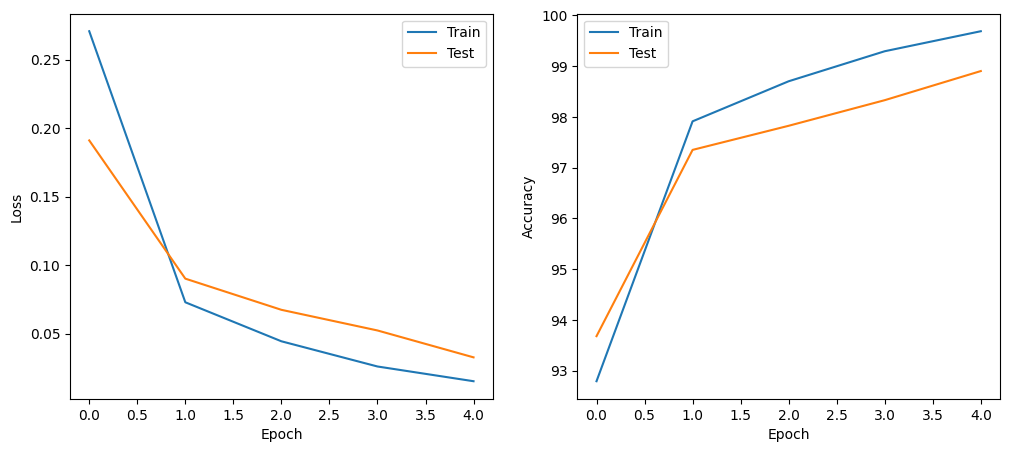

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

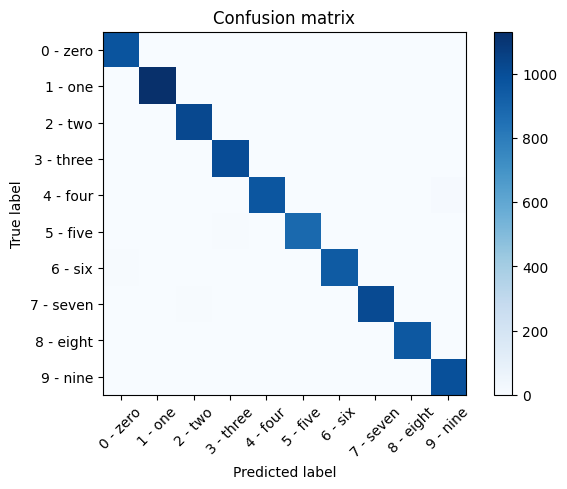

In [13]:
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = KAN_mnist_model(X)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.argmax(dim=1).cpu().numpy())
        test_pred.extend(pred.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, classes=class_names)

In [14]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    0 - zero       0.99      0.99      0.99       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       0.98      0.99      0.99      1032
   3 - three       0.99      0.99      0.99      1010
    4 - four       0.99      0.98      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       1.00      0.99      0.99      1028
   8 - eight       0.98      0.98      0.98       974
    9 - nine       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



9889
111


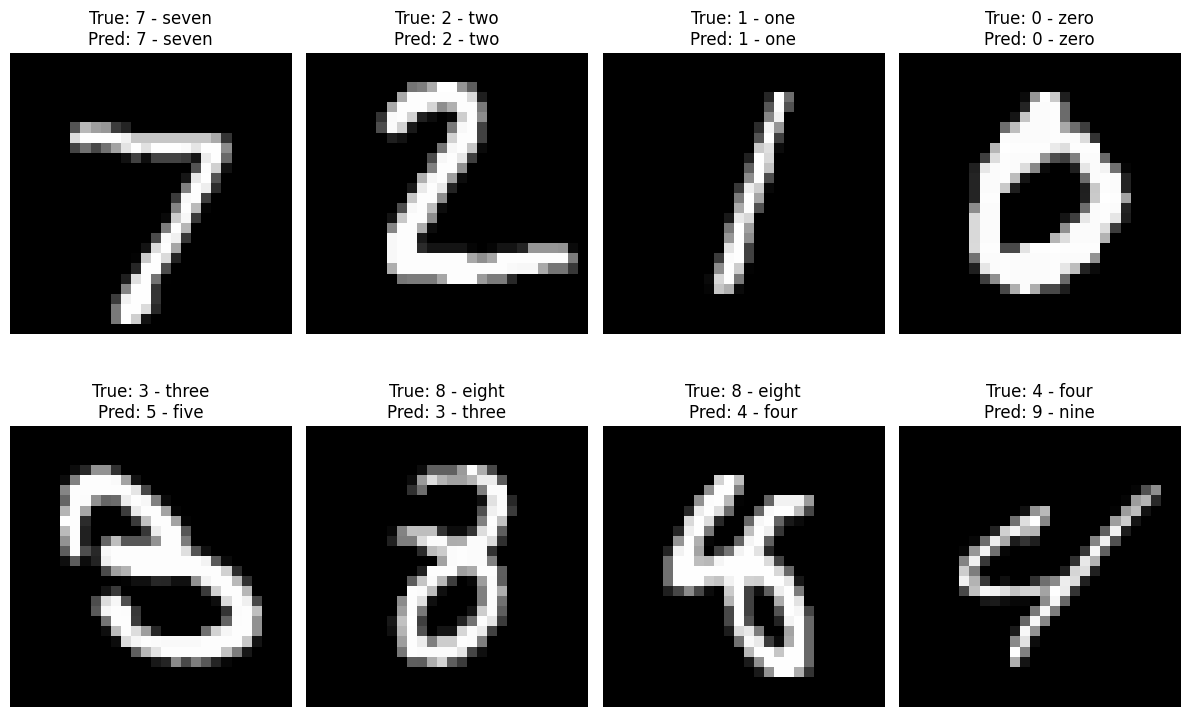

In [15]:
correct_indices = np.where(np.array(y_true) == np.array(y_pred))[0]
incorrect_indices = np.where(np.array(y_true) != np.array(y_pred))[0]

print(len(correct_indices))
print(len(incorrect_indices))

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 4, i+1)
    correct_idx = correct_indices[i]
    plt.imshow(test_data[correct_idx][0].numpy().squeeze(), cmap='gray')
    plt.title(f"True: {class_names[y_true[correct_idx]]}\nPred: {class_names[y_pred[correct_idx]]}")
    plt.axis('off')

    plt.subplot(2, 4, i+5)
    incorrect_idx = incorrect_indices[i]
    plt.imshow(test_data[incorrect_idx][0].numpy().squeeze(), cmap='gray')
    plt.title(f"True: {class_names[y_true[incorrect_idx]]}\nPred: {class_names[y_pred[incorrect_idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()